In [135]:
import os
import math
import cv2
import glob
import zipfile
import scipy
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
from urllib.request import urlretrieve
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import imageio

## Tools and helper functions

In [147]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir

def get_classifier_path():
    return './classifier.pickle'

def save_plt_img(fig_handle, fname):
    plt.figure(fig_handle.number)
    plt.savefig(os.path.join(get_output_dir(), fname + '.jpg'))
    
def save_cv_img(img, fname):
        print("z")
        
def read_img(fname):
    return imageio.imread(fname)

def display_img(img, title):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    
    plt.axis('off')
    plt.title(title)
    
def use_debug():
    return True

## Data loading

In [44]:
def get_img_shape():
    return (40, 40, 3)

def get_dur_label():
    return 0

def get_ilerle_label():
    return 1

def get_saga_label():
    return 2

def get_sola_label():
    return 3

def get_yaya_label():
    return 4

def load_dataset(class_base_folder, class_id):
    f_names = glob.glob(class_base_folder + '*.jpg')
    
    n_img = len(f_names)
    X = np.zeros((n_img,) + get_img_shape(), dtype = np.uint8)
    y = np.zeros((n_img,), dtype = int)
    
    for i in range(n_img):
        X[i] = read_img(f_names[i])
        y[i] = class_id
        
    return X, y

print('Loading datasets...')
Img_dur, y_dur = load_dataset('data/dur/', get_dur_label())
Img_ilerle, y_ilerle = load_dataset('data/ilerle/', get_ilerle_label())
Img_saga, y_saga = load_dataset('data/saga/', get_saga_label())
Img_sola, y_sola = load_dataset('data/sola/', get_sola_label())
Img_yaya, y_yaya = load_dataset('data/yaya/', get_yaya_label())
print('Done...')

Loading datasets...
Done...


In [45]:
print('dur training data: ', Img_dur.shape, y_dur.shape)
print('ilerle training data: ', Img_ilerle.shape, y_ilerle.shape)
print('sola training data: ', Img_sola.shape, y_sola.shape)
print('saga training data: ', Img_saga.shape, y_saga.shape)
print('yaya training data: ', Img_yaya.shape, y_yaya.shape)

Img = np.concatenate((Img_dur, Img_ilerle, Img_sola, Img_saga, Img_yaya))
y = np.concatenate((y_dur, y_ilerle, y_sola, y_saga, y_yaya))

print('Combined dataset: ', Img.shape, y.shape)

dur training data:  (780, 40, 40, 3) (780,)
ilerle training data:  (1200, 40, 40, 3) (1200,)
sola training data:  (420, 40, 40, 3) (420,)
saga training data:  (689, 40, 40, 3) (689,)
yaya training data:  (240, 40, 40, 3) (240,)
Combined dataset:  (3329, 40, 40, 3) (3329,)


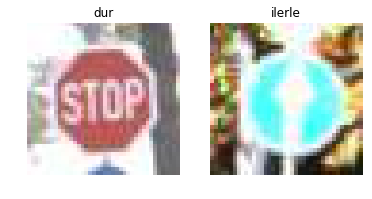

In [46]:
h = plt.figure()
plt.subplot(1,2,1);
display_img(Img_dur[0], 'dur')
plt.subplot(1,2,2);
display_img(Img_ilerle[0], 'ilerle')

save_plt_img(fig_handle=h, fname='dur_ilerle_vehicle')

## Data augmentation


In [47]:
def random_translation(img):
    rows = img.shape[0]
    cols = img.shape[1]
    
    delta_x_max = cols//2
    delta_y_max = rows//2
    
    tr_x = np.random.uniform(-delta_x_max, delta_x_max)
    tr_y = np.random.uniform(-delta_y_max, delta_y_max)

    M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img_out = cv2.warpAffine(img,M,(cols,rows))
    
    return img_out

def augment_image(img):
    return random_translation(img)
    
def augment_data(Img, y):
    augmentation_factor = 2
    
    Img_extra = []
    y_extra = []
    
    for i in range(len(y)):
        for j in range(augmentation_factor):
            Img_extra.append(augment_image(Img[i]))
            y_extra.append(y[i])
    
    Img_extra = np.array(Img_extra)
    y_extra = np.array(y_extra)
    
    Img = np.concatenate((Img, Img_extra))
    y = np.concatenate((y, y_extra))
    
    return Img, y

print('Before data augmentation: ', Img.shape, y.shape)
print('After data augmentation: ', Img.shape, y.shape)

Before data augmentation:  (3329, 40, 40, 3) (3329,)
After data augmentation:  (3329, 40, 40, 3) (3329,)


## Data preprocessing

In [115]:
def rgb_to_ycrcb(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def preprocess_img(Img):
    Img_out = np.copy(Img)
    
    if len(Img.shape) == 3:
        Img_out = rgb_to_ycrcb(Img)
    else:
        for i in range(Img.shape[0]):
            Img_out[i] = cv2.cvtColor(Img[i], cv2.COLOR_RGB2YCrCb)
    
    return Img_out

Img_dur_pp = preprocess_img(Img_dur)
Img_ilerle_pp = preprocess_img(Img_ilerle)
Img_sola_pp = preprocess_img(Img_sola)
Img_saga_pp = preprocess_img(Img_saga)
Img_yaya_pp = preprocess_img(Img_yaya)
Img_pp = preprocess_img(Img)

## HOG feature extraction

In [116]:
def get_pixels_per_cell():
    return 8

def get_hog_features(img, debug=False):
    pix_per_cell = get_pixels_per_cell()
    cell_per_block = 2
    orient = 9

    img_shape = img.shape
    n_channels = img_shape[2]
    
    features = []
    hog_image = np.zeros_like(img)
    
    for i in range(n_channels):
        if debug:
            features_i, hog_image[:, :, i] = hog(img[:, :, i], orientations=orient, 
                                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                                 cells_per_block=(cell_per_block, cell_per_block),
                                                 visualize=debug, feature_vector=False)
        else:
            features_i = hog(img[:, :, i], orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell),
                             cells_per_block=(cell_per_block, cell_per_block),
                             visualize=debug, feature_vector=False)
       
        features.append(features_i)

    features = np.stack(features, axis=-1)
        
    if debug:        
        return features, hog_image
    else:
        return features

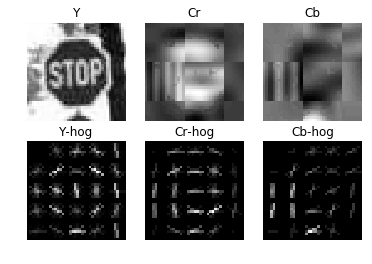

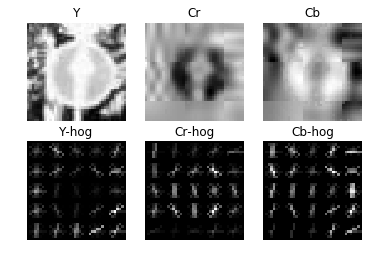

In [117]:
def test_hog_features():
    img_dur = Img_dur_pp[0]
    img_ilerle = Img_ilerle_pp[0]
    img_sola = Img_sola_pp[0]
    img_saga = Img_saga_pp[0]
    img_yaya = Img_yaya_pp[0]

    features_dur, hog_image_dur = get_hog_features(img_dur, debug=True)
    features_ilerle, hog_image_ilerle = get_hog_features(img_ilerle, debug=True)
    features_sola, hog_image_sola = get_hog_features(img_sola, debug=True)
    features_saga, hog_image_saga = get_hog_features(img_saga, debug=True)
    features_yaya, hog_image_yaya = get_hog_features(img_yaya, debug=True)
    
    h = plt.figure()
    img_labels = ['Y', 'Cr', 'Cb']

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        display_img(img_dur[:, :, idx], img_labels[idx])

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        display_img(hog_image_dur[:, :, idx], img_labels[idx] + '-hog')
        
    save_plt_img(fig_handle=h, fname='hog_img_vehicle')
        
    h = plt.figure()
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        display_img(img_ilerle[:, :, idx], img_labels[idx])
        
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        display_img(hog_image_ilerle[:, :, idx], img_labels[idx] + '-hog')
        
    save_plt_img(fig_handle=h, fname='hog_img_non_vehicle')        

test_hog_features()

## HOG Feature extraction from whole image

In [118]:
class SearchWindow:
    
    def __init__(self, x0, y0, size_x, size_y):
        self.x0 = x0
        self.y0 = y0
        self.size_x = size_x
        self.size_y = size_y  
        
    def get_img_contents(self, img):
        return img[self.y0 : self.y0 + self.size_y, 
                   self.x0 : self.x0 + self.size_x]
    
    def resize(self, scale):
        self.x0 = int(self.x0 / scale)
        self.y0 = int(self.y0 / scale)
        self.size_x = int(self.size_x / scale)
        self.size_y = int(self.size_y / scale)
    
    def draw_on_img(self, img, color=(0,0,255), thickness=2):
        p1 = (self.x0,               self.y0)
        p2 = (self.x0,               self.y0 + self.size_y)
        p3 = (self.x0 + self.size_x, self.y0 + self.size_y)
        p4 = (self.x0 + self.size_x, self.y0)
        
        p = (p1, p2, p3, p4)
        
        for i in range(4):
            cv2.line(img, p[i], p[(i+1) % 4], color=color, thickness=thickness)

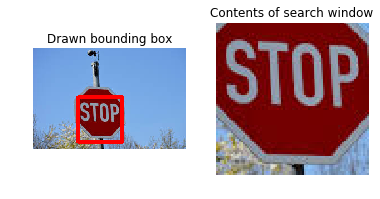

In [119]:
def test_get_img_contents():
    img = read_img('test1.jpg')
    window = SearchWindow(80,90,80,80)
    display_img(window.get_img_contents(img), 'Contents of search window')
    
def test_draw_on_img():
    img = read_img('test1.jpg')
    window = SearchWindow(80,90,80,80)
    window.draw_on_img(img, color = (255,0,0), thickness=5)
    display_img(img, 'Drawn bounding box')

plt.figure();
plt.subplot(1,2,1)
test_draw_on_img()    
plt.subplot(1,2,2)
test_get_img_contents()

In [120]:
def get_hog_features_on_window(hog_features_from_global_img, window, pixels_per_cell):
   
    block_idx_x_start = window.x0 // pixels_per_cell 
    block_idx_y_start = window.y0 // pixels_per_cell

    block_idx_x_end = block_idx_x_start + window.size_x // pixels_per_cell - 1
    block_idx_y_end = block_idx_y_start + window.size_y // pixels_per_cell - 1

    return hog_features_from_global_img[block_idx_y_start : block_idx_y_end,
                                        block_idx_x_start : block_idx_x_end]

(21, 33, 2, 2, 9, 3)
(7, 7, 2, 2, 9, 3)
(7, 7, 2, 2, 9, 3)
Test passed!


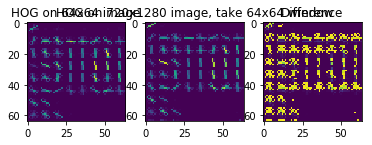

In [121]:
def test_hog_features_window():
    img = preprocess_img(read_img('test1.jpg'))
    img2 = np.copy(img)
    
    x0 = 80
    y0 = 90
    pixels_per_cell = get_pixels_per_cell()
    window = SearchWindow(x0, y0, 64, 64)
    
    sub_img = window.get_img_contents(img)
    features_sub_image, debug1 = get_hog_features(sub_img, debug=True)
    
    hog_features_whole_image, debug2 = get_hog_features(img2, debug=True)
    print(hog_features_whole_image.shape)
    features_sub_hog = get_hog_features_on_window(hog_features_whole_image, window, pixels_per_cell=pixels_per_cell)
    
    print(features_sub_image.shape)
    print(features_sub_hog.shape)
    
    plt.figure()
    plt.subplot(1,3,1)
    plt.title('HOG on 64x64 image')    
    plt.imshow(debug1[:, :, 0])
    plt.subplot(1,3,2)
    plt.title('HOG on 720x1280 image, take 64x64 window')
    plt.imshow(debug2[y0:y0+64,x0:x0+64, 0])
        
    plt.subplot(1,3,3)
    plt.imshow(debug1[:,:,0] - debug2[y0:y0+64,x0:x0+64, 0])
    plt.title('Difference')
        
    assert(features_sub_image.shape == features_sub_hog.shape)
   
    n_blocks = 64 // pixels_per_cell - 1
    
    print('Test passed!')
    
test_hog_features_window()

## Color histogram features

In [122]:
def color_hist_features(img):
    nbins = 32
    bins_range = (0, 256)
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

## Spatial binning features

In [123]:
def bin_spatial(img):
    size = (16, 16)
    return cv2.resize(img, size).ravel()

In [124]:
def combine_features(bin_spatial_feat, color_hist_feat, hog_feat):
    features = []
    
    features.append(bin_spatial_feat)
    features.append(color_hist_feat)
    features.append(hog_feat.ravel())
    
    return np.array(np.concatenate(features))
    
def get_features(img):
    bin_spatial_feat = bin_spatial(img)
    color_hist_feat = color_hist_features(img)
    hog_feat = get_hog_features(img)
    
    return combine_features(bin_spatial_feat, color_hist_feat, hog_feat)
    
def get_features_batch(Img):
    features = []
    for i in range(Img.shape[0]):
        features.append(get_features(Img[i]))
    return np.array(features)

In [125]:
features_file = 'features.pickle'

if not os.path.exists(features_file):
    print('Computing features for the entire dataset...')
    X = get_features_batch(Img_pp)
    print('Saving features into ' + features_file + '...')
    pickle.dump(X, open(features_file, 'wb'))
    print('Done')
else:
    print('Loading features from ' + features_file + '...')
    X = pickle.load(open(features_file, 'rb'))
    print('Done')
    
X = X.astype(np.float64)
print(X.shape)

Computing features for the entire dataset...
Saving features into features.pickle...
Done
(3329, 2592)


## Dataset preparation

In [126]:
def create_scaler(X):
    scaler = StandardScaler().fit(X)
    return scaler

scaler_ = create_scaler(X)

In [127]:
def normalize_features(X):
    return scaler_.transform(X)    

print('Normalizing features...')
X_norm = normalize_features(X)
print('Done')

Normalizing features...
Done


In [128]:
def split_validation(X, y):
    val_ratio = 0.2
    random_state = 918273645
    return train_test_split(X, y, test_size = val_ratio, random_state = random_state)

print('Splitting into train/validation set...')
X_train, X_val, y_train, y_val = split_validation(X_norm, y)

print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)

Splitting into train/validation set...
X_train:  (2663, 2592)
X_val:  (666, 2592)


## Classifier Design

In [129]:
def define_classifier():
    kernel='rbf'
    classifier = LinearSVC(C = 0.001) 
    return classifier

## Training

In [130]:
def train_classifier(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)

In [131]:
def save_classifier(classifier, path):
    joblib.dump(classifier, path)

In [132]:
def load_classifier(path):
    return joblib.load(path)

In [136]:
if not os.path.exists(get_classifier_path()):
    classifier_ = define_classifier()
    
    print('Training classifier...')
    t = time.time()
    train_classifier(classifier_, X_train, y_train)
    print('Done in %.3f s' % (time.time() - t))
    
    save_classifier(classifier_, get_classifier_path())
else:
    print('Loading classifier...')
    classifier_ = load_classifier(get_classifier_path())
    print('Done')

Training classifier...
Done in 2.333 s


## Cross-validation

In [137]:
def compute_validation_accuracy(classifier, X_val, y_val):
    return classifier.score(X_val, y_val)
    
print('Validation accuracy: %.3f%%' % (100. * compute_validation_accuracy(classifier_, X_val, y_val)))

Validation accuracy: 100.000%


In [140]:
def predict(x):
    v = classifier_.decision_function(x)
    

In [141]:
def classify_img(img):
    img = preprocess_img(img)
    
    x = get_features(img)
    x = normalize_features(x)
    
    return predict(x)

## Sliding Window Search

In [152]:
def get_search_windows(img_shape):
    x_start = 0
    y_start = img_shape[0] // 2
    x_end = img_shape[1]
    y_end = img_shape[0]
    
    size = 36
    overlap = 0.75    

    bboxes_out = []
    step = int((1.0 - overlap) * size) 

    for y in range(y_start, y_end - size, step):
        for x in range(x_start, x_end - size, step):                
            box = SearchWindow(x, y, size, size)
            bboxes_out.append(box)
        
    return bboxes_out

In [153]:
def draw_search_windows(img, windows, color, thickness):
    for w in windows:
        w.draw_on_img(img, color, thickness)

Obtained 189 boxes
z


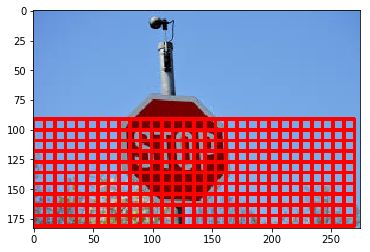

In [154]:
def test_bboxes():
    img = read_img('test1.jpg')
    bboxes = get_search_windows(img.shape)
    print('Obtained %d boxes' % len(bboxes))
    draw_search_windows(img, bboxes, color=(255,0,0), thickness=2)
    plt.imshow(img)
    save_cv_img(fname= 'search_boxes', img=img)
    
test_bboxes()

## Heat map

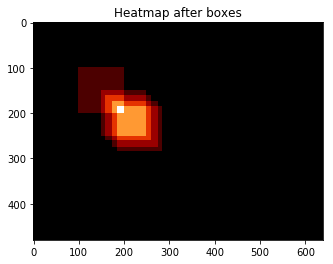

In [155]:
def create_heatmap(shape):
    return np.zeros(shape, dtype = np.uint8)
    
def add_heat(heatmap, boxes):
    for box in boxes:
        x_start = box.x0
        x_end = x_start + box.size_x
        y_start = box.y0
        y_end = y_start + box.size_y

        heatmap[y_start:y_end, x_start:x_end] += 1


def extract_boxes_from_heatmap(heatmap, threshold):
    heatmap_thresh = np.zeros_like(heatmap)
    heatmap_thresh[heatmap > threshold] = 255

    _, contours, _ = cv2.findContours(heatmap_thresh.copy(), mode = cv2.RETR_LIST,
                                      method = cv2.CHAIN_APPROX_SIMPLE)
    vehicles_out = []
    for contour in contours:
        (x0, y0, size_x, size_y) = cv2.boundingRect(contour)            
        vehicles_out.append(SearchWindow(x0, y0, size_x, size_y))

    return vehicles_out, heatmap_thresh
    
def normalize(x, new_max):
    d_min = float(np.amin(x))
    d_max = float(np.amax(x))

    return (((x - d_min) / (d_max - d_min)) * new_max).astype(x.dtype)

def test_update_heat_map():
    heatmap = create_heatmap((480,640))
    
    boxes = []
    boxes.append(SearchWindow(100,100,100,100))
    boxes.append(SearchWindow(150, 150, 100,100))
    boxes.append(SearchWindow(160, 160, 100,100))
    boxes.append(SearchWindow(175, 175, 100,100))
    boxes.append(SearchWindow(185, 185, 100,100))
        
    add_heat(heatmap, boxes)
    
    h = plt.figure()
    plt.imshow(heatmap.data, cmap='gist_heat')
    plt.title('Heatmap after boxes')
    
test_update_heat_map()

## Single Image pipeline

In [156]:
class SingleImagePipeline:
    def __init__(self, debug = False):
        self.debug = debug
        self.pixels_per_cell = get_pixels_per_cell()
        self.scales = [1.0, 0.75, 0.5]
        self.threshold = 2
    def run(self, img):
        heatmap = create_heatmap(img.shape[0:2])

        img_pp = preprocess_img(img)
        
        for scale in self.scales:
            img_s = cv2.resize(img_pp, dsize = (0,0), fx = scale, fy = scale)
            
            img_hog_features = get_hog_features(img_s)

            search_windows = get_search_windows(img_s.shape)

        
        if self.debug:
            plt.figure()
            plt.imshow(heatmap, cmap='gist_heat')
                    
            return img
        else:
            return heatmap

## Test on images

In [ ]:
test_images = glob.glob('test1.jpg')

for img_path in test_images:
    _,img_name = os.path.split(img_path)
    
    img = read_img(img_path)
    
    pipeline = SingleImagePipeline(debug = True)
    
    t = time.time()
    img_out = pipeline.run(img)
    print('Time for complete image: %.3f s' % (time.time() - t))
    
    plt.figure();
    display_img(img_out, img_name);
    